<a href="https://colab.research.google.com/github/julianovale/BB_Evolution/blob/main/0021_AluraBB_RedesNeurais_TreinandoRedeNeural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

args = {
    'batch_size': 20,
    'num_workers': 2,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 250
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Baixando o Dataset

Veja neste site a descrição: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

In [2]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip

--2021-06-09 20:10:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  --.-KB/s    in 0.1s    

2021-06-09 20:10:43 (2.42 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [3]:
! ls


Bike-Sharing-Dataset.zip  day.csv  hour.csv  Readme.txt  sample_data


# Visualizando dados

In [4]:
df = pd.read_csv('hour.csv')
print(len(df))
df.head()

17379


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
df.shape

(17379, 17)

# Tratamento de dados

In [6]:
torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))
df_train = df.iloc[indices[:train_size]]
df_test = df.iloc[indices[train_size:]]

print(len(df_train), len(df_test))
display(df_test.head())

df_train.to_csv('bike_train.csv', index=False)
df_test.to_csv('bike_test.csv', index=False)

! ls

13903 3476


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12663,12664,2012-06-16,2,1,6,20,0,6,0,2,0.66,0.6212,0.47,0.1940,123,229,352
1801,1802,2011-03-20,1,0,3,18,0,0,0,1,0.38,0.3939,0.40,0.3582,58,98,156
16567,16568,2012-11-28,4,1,11,1,0,3,1,2,0.26,0.2576,0.75,0.2239,0,12,12
8817,8818,2012-01-08,1,1,1,5,0,0,0,2,0.32,0.3333,0.49,0.1045,0,2,2
2608,2609,2011-04-23,2,0,4,14,0,6,0,1,0.58,0.5455,0.78,0.3582,182,209,391


Bike-Sharing-Dataset.zip  bike_train.csv  hour.csv    sample_data
bike_test.csv		  day.csv	  Readme.txt


# Classe Dataset

In [7]:
class Bicicletinha(Dataset):
  def __init__(self, csv_path):
    self.dados = pd.read_csv(csv_path).to_numpy()

  def __getitem__(self, idx):
    sample = self.dados[idx][2:14]
    label = self.dados[idx][-1:] 

    # converte para tensor
    sample = torch.from_numpy(sample.astype(np.float32))
    label = torch.from_numpy(label.astype(np.float32))

    return sample, label

  def __len__(self):
    return len(self.dados)

# Construindo conjuntos de treinamento e teste

In [8]:
train_set = Bicicletinha('bike_train.csv')
test_set = Bicicletinha('bike_test.csv')

dado, rotulo = train_set[0]
print(rotulo)
print(dado)

tensor([373.])
tensor([ 4.0000,  1.0000, 11.0000, 19.0000,  0.0000,  4.0000,  1.0000,  1.0000,
         0.3800,  0.3939,  0.2700,  0.3582])


# Dataloader

In [9]:
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers']
                          ) 

test_loader = DataLoader(test_set,
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers']
                          )

In [10]:
for batch in train_loader:
  
  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  break

torch.Size([20, 12]) torch.Size([20, 1])


# Implementando MLP

In [11]:
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features  = nn.Sequential(
                      nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU()
                    )
    self.out     = nn.Linear(hidden_size, out_size)

  def forward(self, X):

    feature = self.features(X)
    output  = self.out(feature)

    return output

input_size  = len(train_set[0][0])
hidden_size = 128
out_size    = 1 # para regressão é "um" 

net = MLP(input_size, hidden_size, out_size).to(args['device']) #cast na GPU

In [12]:
net

MLP(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)

# Definindo função-objetivo (Loss) e otimizador

In [13]:
criterion = nn.L1Loss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Fluxo de treinamento e validação

In [14]:
def train(train_loader, net, epoch):

  net.train()

  epoch_loss = []

  for batch in train_loader:
    
    dado, rotulo = batch

    # Cast na GPU
    dado = dado.to(args['device']) 
    rotulo = rotulo.to(args['device']) 

    # Foward
    pred = net(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)

  print("*************** TRAIN ***************")
  print("Época: %d, Loss: %.4f +\- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()))

  return epoch_loss.mean()

In [15]:
def test(test_loader, net, epoch):

  net.eval()
  with torch.no_grad():

    epoch_loss = []
    
    for batch in test_loader:
      
      dado, rotulo = batch

      # Cast na GPU
      dado = dado.to(args['device']) 
      rotulo = rotulo.to(args['device']) 

      # Foward
      pred = net(dado)
      loss = criterion(pred, rotulo)
      epoch_loss.append(loss.cpu().data)

    epoch_loss = np.asarray(epoch_loss)
    
    print("************** VALIDATE *************")
    print("Época: %d, Loss: %.4f +\- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()))

  return epoch_loss.mean()

In [16]:
train_losses, test_losses = [], []

for epoch in range(args['num_epochs']):
  train_losses.append(train(train_loader, net, epoch))
  test_losses.append(test(test_loader, net, epoch))

*************** TRAIN ***************
Época: 0, Loss: 147.6601 +\- 38.9170
************** VALIDATE *************
Época: 0, Loss: 120.5032 +\- 22.2194
*************** TRAIN ***************
Época: 1, Loss: 123.9489 +\- 31.9758
************** VALIDATE *************
Época: 1, Loss: 118.0498 +\- 22.1779
*************** TRAIN ***************
Época: 2, Loss: 122.3501 +\- 29.6726
************** VALIDATE *************
Época: 2, Loss: 124.3501 +\- 30.6589
*************** TRAIN ***************
Época: 3, Loss: 119.2735 +\- 27.6364
************** VALIDATE *************
Época: 3, Loss: 113.7800 +\- 27.2837
*************** TRAIN ***************
Época: 4, Loss: 117.9124 +\- 30.2453
************** VALIDATE *************
Época: 4, Loss: 123.5241 +\- 21.1417
*************** TRAIN ***************
Época: 5, Loss: 112.0966 +\- 27.7875
************** VALIDATE *************
Época: 5, Loss: 102.1424 +\- 25.9265
*************** TRAIN ***************
Época: 6, Loss: 105.9192 +\- 25.1956
************** VALIDATE *

In [17]:
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(args['device'])

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest, ypred), axis=1)

df_results = pd.DataFrame(data, columns=['ypred', 'ytest'])
df_results.head(20)

,ypred,ytest
0,tensor(352.),tensor(287.4724)
1,tensor(156.),tensor(103.3477)
2,tensor(12.),tensor(8.2654)
3,tensor(2.),tensor(8.2654)
4,tensor(391.),tensor(319.0505)
5,tensor(391.),tensor(290.9761)
6,tensor(84.),tensor(152.1710)
7,tensor(487.),tensor(337.6906)
8,tensor(176.),tensor(237.6699)
9,tensor(157.),tensor(135.3884)


# Gráfico de convergência

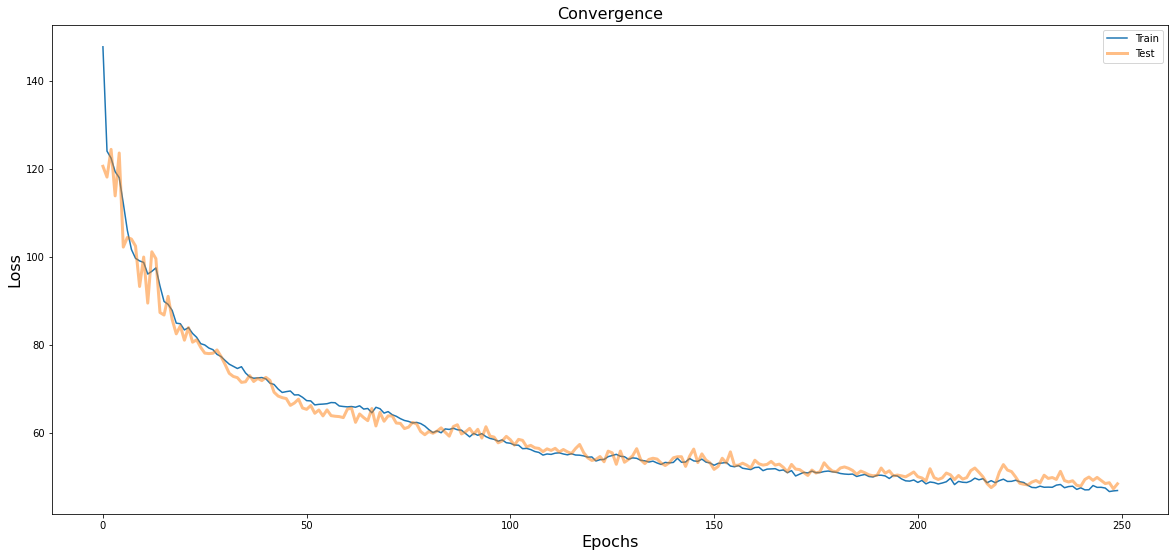

In [18]:
plt.figure(figsize=(20,9))
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test", linewidth=3, alpha=0.5)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Convergence", fontsize=16)
plt.legend()
plt.show()